# Run Camera Calibration to Remove Distortion

Determine calibration matrices corresponding to lens abberation. This can then be used to cancel out the distortion on the camera's images. This is important for the Spatial Power spectrum, as these distortions change the resulting spatial frequencies

## Dependencies

In [1]:
import os, stat
import numpy as np
import msgpack
import cv2
import matplotlib.pyplot as plt
import utils.traceconvert as traceconvert
import random
import glob
import yaml
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15.0, 10.0)


## Parameters

*** NOTE: REALLY NEED TO CHECK ON THE VALUES FOR HORIZONTAL AND VERTICAL FOV ***

In [2]:
base_dir = '/hmet_data/calibration/'
data_dir = os.path.join(base_dir, 'raw', '2020_11_27', '000')
#data_dir = os.path.join(base_dir, 'raw', '2020_10_07', '000')
output_dir = os.path.join(base_dir, 'analysis')
#output_dir = os.path.join(base_dir, 'analysis')
#output_dir = './output/matched_frames'

fps = 200

###DEFINITELY NEED TO CHECK ON THESE VALUES
horizontal_fov_deg = 61
#vertical_fov_deg = 61

img_dims=(1544,2064)
save_batchsize = 200


## Specify Directories for Exmaple

In [3]:
example_subject = 'bu'
example_trial = 'calibration'
iteration = '6'
trial_directory = os.path.join(data_dir, example_subject, iteration)
pngs_dir = os.path.join(base_dir, 'pngs', example_trial, example_subject, iteration)
save_dir = os.path.join('./output', example_trial, example_subject, iteration)
try:
    os.makedirs(save_dir)
except:
    print(f'{save_dir} already made!')

analysis_folder = os.path.join(output_dir, example_trial, example_subject, iteration)
common_timeline_file = os.path.join(analysis_folder,'common_timeline.npy')
#pupil_positions_file = os.path.join(trial_directory, 'eye_camera','000','exports','000','pupil_positions.csv')

#three trace conditions: true, none, temporal_match, spatial_match 
#trace_type='fixation_eye_0
#trace_type='none'


./output/calibration/bu/6 already made!


## Create Matched Frameset

In [4]:
common_timeline_file = os.path.join(analysis_folder,'common_timeline.csv')
common_timeline_depth_idx_file = os.path.join(analysis_folder, 'common_timeline_depth_sampleidx.csv')
common_timeline_rsrgb_idx_file = os.path.join(analysis_folder, 'common_timeline_rsrgb_sampleidx.csv')
common_timeline_ximea_idx_file = os.path.join(analysis_folder, 'common_timeline_ximea_sampleidx.csv')

common_timeline = np.genfromtxt(common_timeline_file)
common_timeline_depth_idx = np.genfromtxt(common_timeline_depth_idx_file)
common_timeline_rsrgb_idx = np.genfromtxt(common_timeline_rsrgb_idx_file)
common_timeline_ximea_idx = np.genfromtxt(common_timeline_ximea_idx_file)

#these should all be the same length
print(len(common_timeline), len(common_timeline_depth_idx),len(common_timeline_rsrgb_idx),len(common_timeline_ximea_idx ))

3030 3030 3030 3030


In [5]:
rsrgb_movie_path =  os.path.join(data_dir, 'world.mp4')
cap = cv2.VideoCapture(rsrgb_movie_path)

rerun=False

if(rerun):
    os.makedirs(os.path.join(output_dir,'matched_frames','depth'),exist_ok=True)
    os.makedirs(os.path.join(output_dir,'matched_frames','rsrgb'),exist_ok=True)
    os.makedirs(os.path.join(output_dir,'matched_frames','ximea'),exist_ok=True)
    for i in range(len(common_timeline)):
        print('*',end='')

        #save appropriate depth file as png
        depth_in_path = os.path.join(data_dir, 'depth', f'depth_frame_{int(common_timeline_depth_idx[i])}.npy')
        #depth_out_path = os.path.join(output_dir, 'matched_frames','depth',f'depth_frame_{i}.png')
        depth_out_path = os.path.join(output_dir, 'matched_frames','depth',f'depth_frame_{i}.npy')
        depth_frame = np.load(depth_in_path)
        #cv2.imwrite(depth_out_path, depth_frame)
        np.save(depth_out_path, depth_frame)

        #save appropriate rsrgb frame as png
        cap.set(1, int(common_timeline_rsrgb_idx[i]))
        res, rsrgb_frame = cap.read()
        rsrgb_out_path = os.path.join(output_dir, 'matched_frames','rsrgb',f'rsrgb_frame_{i}.png')
        cv2.imwrite(rsrgb_out_path, rsrgb_frame)

        #save appropriate ximea frame as png
        ximea_in_path = os.path.join(pngs_dir, f'frame_{int(common_timeline_ximea_idx[i])}.png')
        ximea_out_path = os.path.join(output_dir, 'matched_frames','ximea',f'ximea_frame_{i}.png')
        ximea_frame = cv2.imread(ximea_in_path)
        cv2.imwrite(ximea_out_path, ximea_frame)

    cap.release()
else:
    i=10
    rsrgb_frame = cv2.imread(os.path.join(output_dir, 'matched_frames','rsrgb',f'rsrgb_frame_{i}.png'))
    depth_frame = np.load(os.path.join(output_dir, 'matched_frames','depth',f'depth_frame_{i}.npy'))
    ximea_frame = cv2.imread(os.path.join(output_dir, 'matched_frames','ximea',f'ximea_frame_{i}.png'))
    

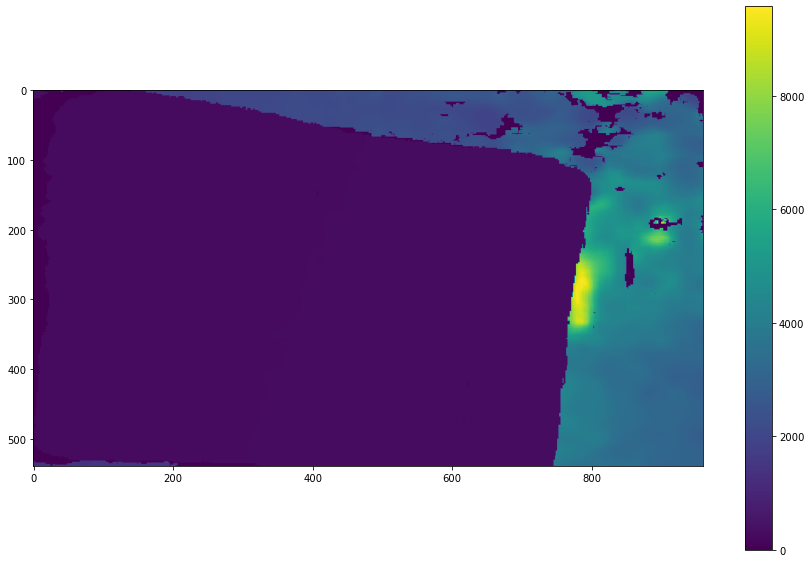

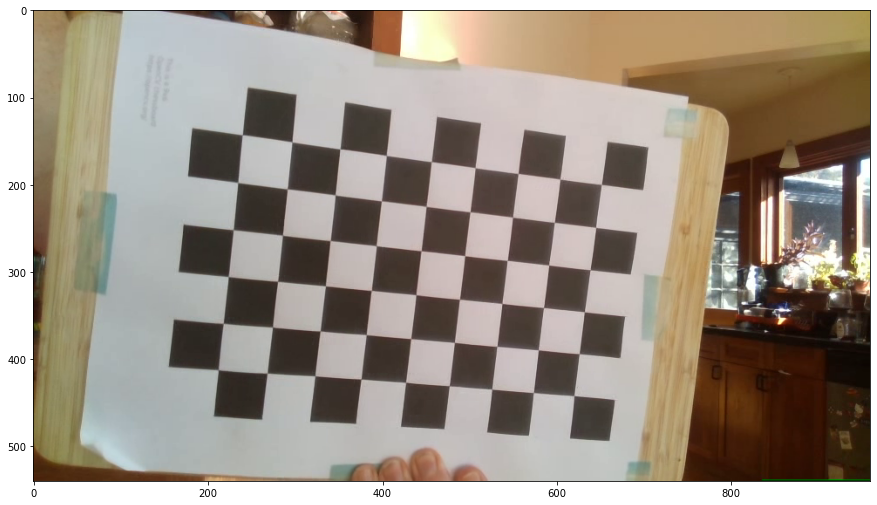

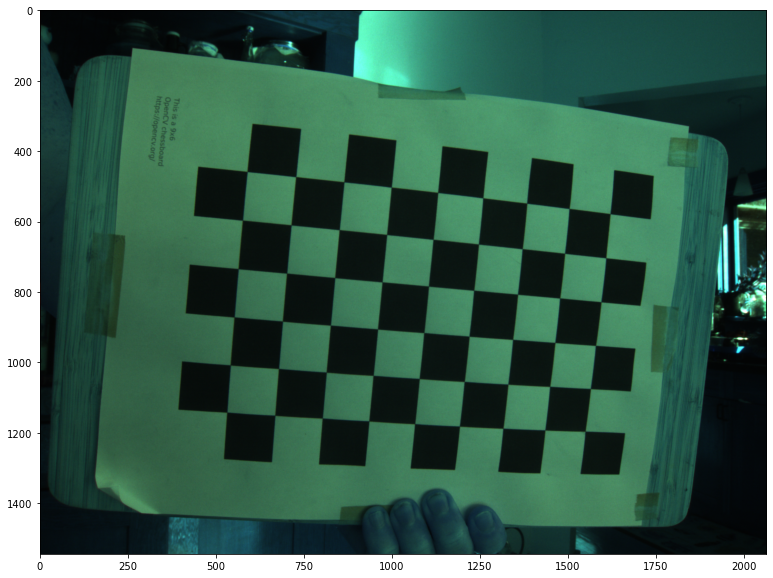

In [6]:
import matplotlib.pyplot as plt
plt.imshow(depth_frame)
plt.colorbar()
plt.show()
plt.imshow(cv2.cvtColor(rsrgb_frame, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(ximea_frame)
plt.show()

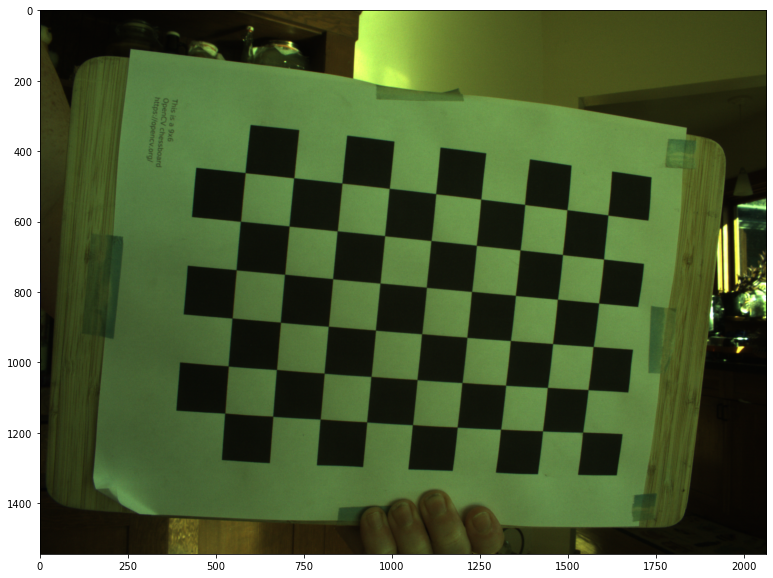

In [7]:
i=0
ximea_frame = cv2.imread(os.path.join(output_dir, 'matched_frames','ximea',f'ximea_frame_{i}.png'))
plt.imshow(cv2.cvtColor(ximea_frame, cv2.COLOR_BGR2RGB))
#plt.imshow(ximea_frame)

## These depth values are in mm

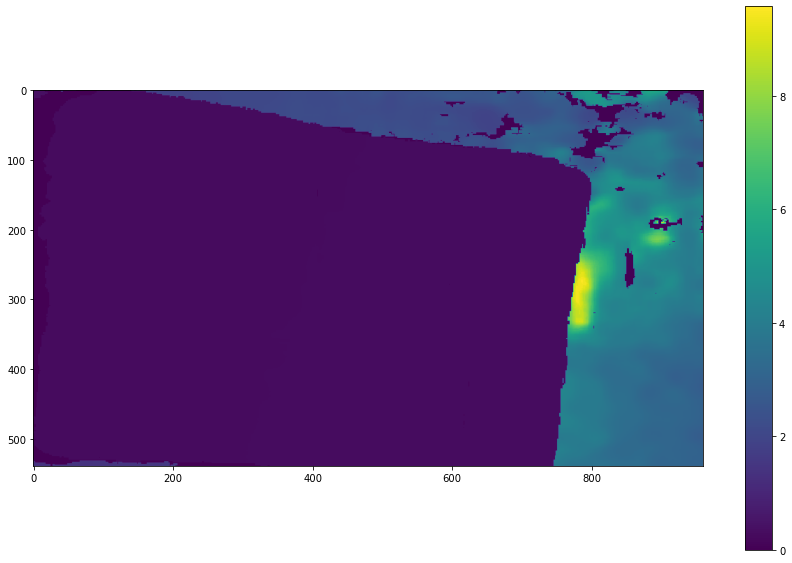

In [8]:
#i=0
# depth_path = os.path.join(output_dir, 'matched_frames','depth',f'depth_frame_{i}.npy')
# df = np.load(depth_path)
# df
# #cv2.imread(depth_path)
plt.imshow(depth_frame/1000)
plt.colorbar()

## Use Frames to Calculate Ximea Lens Distortion
from https://longervision.github.io/2017/03/18/ComputerVision/OpenCV/opencv-internal-calibration-circle-grid/

for grid: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html

*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#**#*#*#*#*#*#*#*#*#**#*#*#*#*#*#*#*#**#*#*#*#*#*#*#*#*#**#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#**#*#*#*#*#*#*#*#*#*#*#*#*#*#*#**#*#*#*#*#*#*#*#*#*#*#*#*#*#**#*#*#*#*#*#*#*#*#*#*#

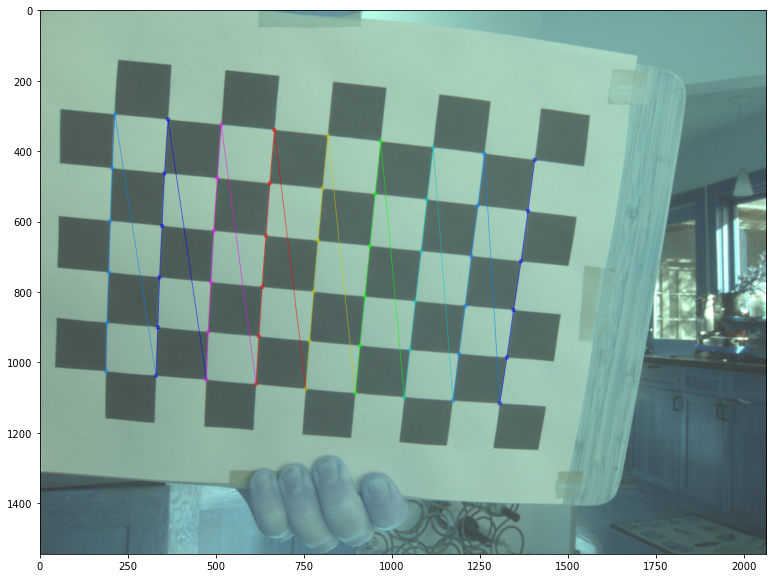

In [9]:
maxframes=100
nrows = 9
ncols = 6

ximea_path = os.path.join(output_dir, 'matched_frames','ximea',f'ximea_frame_*.png')
images = glob.glob(ximea_path)
random.shuffle(images)

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nrows*ncols,3), np.float32)
objp[:,:2] = np.mgrid[0:ncols,0:nrows].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
nfound=0

for fname in images:
    print('*',end='')
    img = cv2.imread(fname)
    img = traceconvert.adjust_gamma(img,gamma=3) #adjust gamma, brighten
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (ncols,nrows),None)
    #If found, add object points, image points (after refining them)
    if ret == True:
        print('#',end='')
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)
        nfound += 1
        if nfound >= maxframes:
            im_with_keypoints = cv2.drawChessboardCorners(img, (ncols,nrows), corners, ret)
            plt.imshow(im_with_keypoints)
            plt.show()
            break;
#         # Draw and display the corners
#         img = cv2.drawChessboardCorners(img, (7,6), corners2,ret)
#         cv2.imshow('img',img)
        


In [10]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


In [11]:
# It's very important to transform the matrix to list.
data = {'camera_matrix': np.asarray(mtx).tolist(), 'dist_coeff': np.asarray(dist).tolist()}
with open("calibration_ximea_distortion.yaml", "w") as f:
    yaml.dump(data, f)

In [12]:
with open('calibration_ximea_distortion.yaml') as f:
    loadeddict = yaml.load(f, Loader=yaml.BaseLoader)
mtxloaded = loadeddict.get('camera_matrix')
distloaded = loadeddict.get('dist_coeff')

In [13]:
h, w = img.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
#newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist)

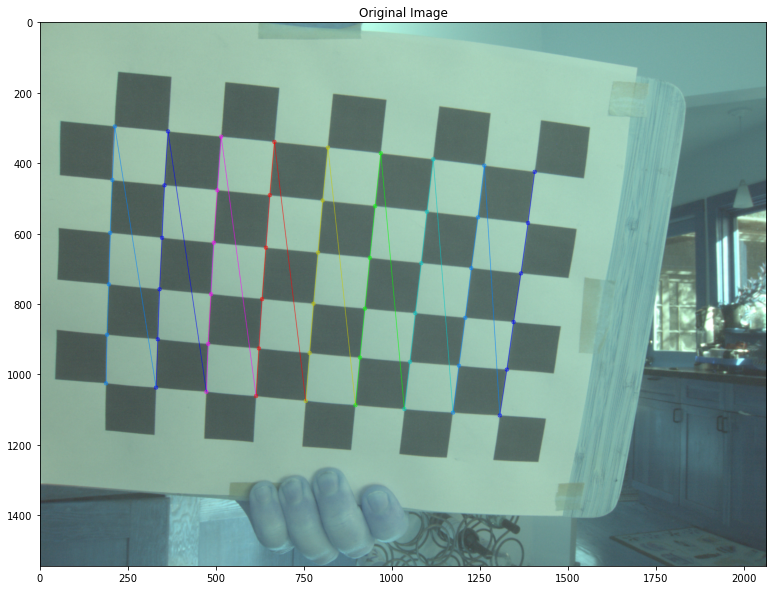

Text(0.5, 1.0, 'Undistorted Image')

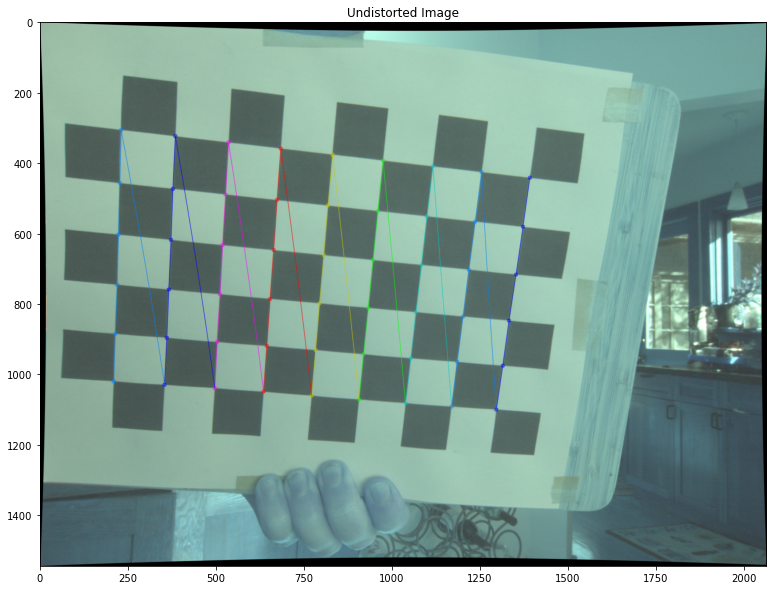

In [14]:
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
plt.imshow(img)
plt.title('Original Image')
plt.show()
plt.imshow(dst)
plt.title('Undistorted Image')

 Getting A very similar undistorted frame running the calibration mulitple times with a different subset of 100 frames from the video.